In [3]:
!wget -N http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx -P /notebooks/analytics/datasets/

--2024-01-15 22:54:05--  http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘/notebooks/analytics/datasets/Online Retail.xlsx’

Online Retail.xlsx      [      <=>           ]  22.62M  21.8MB/s    in 1.0s    

Last-modified header missing -- time-stamps turned off.
2024-01-15 22:54:08 (21.8 MB/s) - ‘/notebooks/analytics/datasets/Online Retail.xlsx’ saved [23715344]



In [1]:
!pip install -q btyd==0.1a1 lifetimes==0.11.3 openpyxl==3.1.2

### Data Understanding

In [2]:
import pandas as pd
import numpy as np

In [3]:
orders_schema = {
  'InvoiceNo': str,
  'StockCode': str,
  'Description': str,
  'Quantity': np.int64,
  'InvoiceDate': np.datetime64,
  'UnitPrice': np.float64,
  'CustomerID': str,
  'Country': str  
}

In [4]:
df = pd.read_excel(
    "./datasets/Online Retail.xlsx",
    sheet_name='Online Retail',
    header=0,
    dtype=orders_schema
)

In [5]:
df['SalesAmount'] = df['Quantity'] * df['UnitPrice']

In [6]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,SalesAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
 8   SalesAmount  541909 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 37.2+ MB


In [8]:
!pip install -q pyspark

In [9]:
from pyspark.sql import SparkSession

In [10]:
spark = SparkSession \
    .builder \
    .appName("Customer Lifetime Value") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/16 22:29:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [11]:
spark.sparkContext.setLogLevel('ERROR')

In [12]:
orders = spark.createDataFrame(df)

In [13]:
orders.createOrReplaceTempView("orders")

In [14]:
query = spark.sql(
"""
    SELECT 
        CustomerID,
        TO_DATE(InvoiceDate) as InvoiceDate,
        COUNT(DISTINCT InvoiceNo) as Transactions,
        SUM(SalesAmount) as SalesAmount
    FROM 
        orders
    GROUP BY 
        CustomerID, TO_DATE(InvoiceDate)
    ORDER BY 
        CustomerID, InvoiceDate;
""")

In [15]:
query.show()

+----------+-----------+------------+------------------+
|CustomerID|InvoiceDate|Transactions|       SalesAmount|
+----------+-----------+------------+------------------+
|     12346| 2011-01-18|           2|               0.0|
|     12347| 2010-12-07|           1|            711.79|
|     12347| 2011-01-26|           1|            475.39|
|     12347| 2011-04-07|           1|            636.25|
|     12347| 2011-06-09|           1|            382.52|
|     12347| 2011-08-02|           1|            584.91|
|     12347| 2011-10-31|           1|1294.3200000000002|
|     12347| 2011-12-07|           1|224.82000000000002|
|     12348| 2010-12-16|           1| 892.8000000000001|
|     12348| 2011-01-25|           1|227.43999999999997|
|     12348| 2011-04-05|           1|             367.0|
|     12348| 2011-09-25|           1|             310.0|
|     12349| 2011-11-21|           1|           1757.55|
|     12350| 2011-02-02|           1|334.40000000000003|
|     12352| 2011-02-16|       

In [16]:
import pyspark.sql.functions as fn

#### Identify Outlier Customers

In [19]:
query = (
    orders.groupBy("customerid", "invoicedate")
    .agg(fn.sum("salesamount").alias("salesamount"))
    .filter("salesamount > 70000")
    .select("customerid", "salesamount")
    .distinct()
)

In [20]:
query.show()

+----------+-----------+
|customerid|salesamount|
+----------+-----------+
|     12346|    77183.6|
|     16446|   168469.6|
+----------+-----------+



#### Remove Outlier Customer and Bad Records

In [21]:
customers_to_exclude = (
    orders.groupBy("customerid", "invoicedate")
    .agg(fn.sum("salesamount").alias("salesamount"))
    .filter("salesamount > 70000")
    .select("customerid")
    .distinct()
)

In [22]:
cleansed_orders = orders.filter(
    "customerid is not null and not isnan(customerid)"
).join(customers_to_exclude, on="customerid", how="leftanti")

In [23]:
cleansed_orders.createOrReplaceTempView("orders")

In [24]:
clean_df = cleansed_orders.toPandas()

### Exploratory Data Analysis

#### Transactions By Month

In [25]:
query = spark.sql(
"""
    SELECT 
      TRUNC(InvoiceDate, 'month') as InvoiceMonth,
      COUNT(DISTINCT InvoiceNo) as Transactions,
      SUM(SalesAmount) as SalesAmount
    FROM 
        orders
    GROUP BY 
        TRUNC(InvoiceDate, 'month') 
    ORDER BY 
        InvoiceMonth;
""")

In [26]:
query.show()

+------------+------------+------------------+
|InvoiceMonth|Transactions|       SalesAmount|
+------------+------------+------------------+
|  2010-12-01|        1708| 554604.0199999996|
|  2011-01-01|        1234|475074.37999999966|
|  2011-02-01|        1202| 436546.1499999999|
|  2011-03-01|        1619| 579964.6099999996|
|  2011-04-01|        1384| 426047.8510000005|
|  2011-05-01|        1848| 648248.1799999994|
|  2011-06-01|        1707| 608013.1600000001|
|  2011-07-01|        1593| 574238.4810000001|
|  2011-08-01|        1544| 616367.9999999999|
|  2011-09-01|        2078| 931440.3720000014|
|  2011-10-01|        2263| 974603.5899999996|
|  2011-11-01|        3086|1132407.7400000012|
|  2011-12-01|         919| 342506.3800000002|
+------------+------------+------------------+



#### Summary Metrics

In [27]:
query = spark.sql(
"""
    SELECT
        COUNT(DISTINCT CustomerID) as Customers,
        COUNT(DISTINCT InvoiceNo) as Transactions,
        SUM(SalesAmount) as SalesAmount
    FROM 
        orders
    WHERE 
        CustomerID IS NOT NULL and InvoiceDate<'2011-12-01';
""")

In [28]:
query.show()

+---------+------------+-----------------+
|Customers|Transactions|      SalesAmount|
+---------+------------+-----------------+
|     4329|       21266|7957556.534000329|
+---------+------------+-----------------+



#### Distribution of Per-Customer Purchase Date Counts

In [29]:
query = spark.sql(
"""
    SELECT
      x.Transactions,
      COUNT(x.*) as Occurrences
    FROM (
      SELECT
        CustomerID,
        COUNT(DISTINCT TO_DATE(InvoiceDate)) as Transactions
      FROM 
        orders
      GROUP BY 
        CustomerID
      ) x
    GROUP BY 
      x.Transactions
    ORDER BY
      x.Transactions;
""")

In [30]:
query.show()

+------------+-----------+
|Transactions|Occurrences|
+------------+-----------+
|           1|       1380|
|           2|        857|
|           3|        499|
|           4|        388|
|           5|        277|
|           6|        197|
|           7|        149|
|           8|        116|
|           9|         70|
|          10|         71|
|          11|         54|
|          12|         40|
|          13|         35|
|          14|         25|
|          15|         23|
|          16|         22|
|          17|         23|
|          18|         22|
|          19|          9|
|          20|         11|
+------------+-----------+
only showing top 20 rows



#### Avg Number Days between Purchase Dates

In [31]:
query = spark.sql(
"""
    WITH CustomerPurchaseDates AS (
        SELECT DISTINCT
            CustomerID,
            TO_DATE(InvoiceDate) as InvoiceDate
        FROM 
            orders 
        )
    SELECT
        a.CustomerID,
        AVG(DATEDIFF(a.NextInvoiceDate, a.InvoiceDate)) as AvgDaysBetween
    FROM (
        SELECT 
            x.CustomerID,
            x.InvoiceDate,
            MIN(y.InvoiceDate) as NextInvoiceDate
        FROM 
            CustomerPurchaseDates x
            INNER JOIN CustomerPurchaseDates y ON x.CustomerID=y.CustomerID AND x.InvoiceDate < y.InvoiceDate
        GROUP BY 
            x.CustomerID,
            x.InvoiceDate
        ) a
    GROUP BY 
        CustomerID;

""")

In [32]:
query.show()

+----------+------------------+
|CustomerID|    AvgDaysBetween|
+----------+------------------+
|     12347|60.833333333333336|
|     12348| 94.33333333333333|
|     12352|43.333333333333336|
|     12356|             151.5|
|     12358|             149.0|
|     12359|              64.8|
|     12360|              74.0|
|     12362|24.333333333333332|
|     12363|             133.0|
|     12364|              35.0|
|     12370|             103.0|
|     12371|              15.0|
|     12372|             112.5|
|     12375|              48.0|
|     12377|              39.0|
|     12379|              44.5|
|     12380|              41.0|
|     12381|              23.0|
|     12383|              33.6|
|     12384|              46.5|
+----------+------------------+
only showing top 20 rows



Focusing on customers with repeat purchases, we can examine the distribution of the days between purchase events. What's important to note here is that most customers return to the site within 2 to 3 months of a prior purchase.

#### Sales Distribution

In [33]:
query = spark.sql(
"""
    SELECT
        SUM(SalesAmount) as SalesAmount
    FROM 
        orders
    GROUP BY 
        CustomerID, TO_DATE(InvoiceDate)
    HAVING 
        SalesAmount BETWEEN 0 AND 2500
""")

In [34]:
import matplotlib.pyplot as plt

In [35]:
sales_distribution = query.rdd.flatMap(lambda x: x).collect()

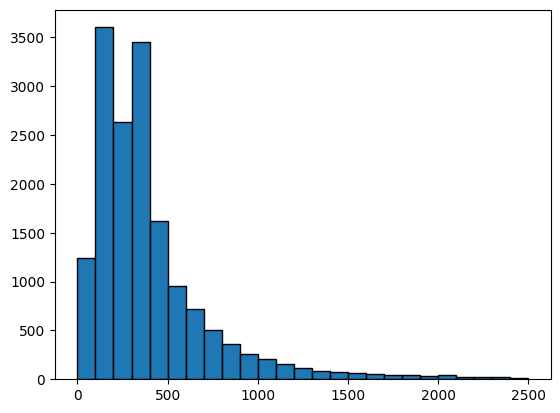

In [38]:
_  = plt.hist(sales_distribution, bins=25, edgecolor='black')

The distribution of daily spend in this narrowed range is centered around 200 to 400 pound sterling with a **long-tail** towards higher ranges of spend. This is not a normal (gaussian) distribution.

### Data Preparation

#### Calculate Customer Metrics

**Buy 'til You Die (BTYD) models**
1. Frequency - the number of dates on which a customer made a purchase **subsequent to the date of the customer's first purchase**
2. Age (Term) - the number of time units, e.g. days, since the date of a customer's first purchase to the current date (or last date in the dataset)
3. Recency - the age of the customer (as previously defined) at the time of their last purchase
4. Monetary Value - the average per transaction-date spend by a customer during repeat purchases.

In [65]:
customer_transaction_per_date = (
    orders.withColumn("transaction_date", fn.to_date("invoicedate"))
    .groupBy("customerid", "transaction_date")
    .agg(fn.sum("salesamount").alias("salesamount"))
)

In [66]:
customer_first_transaction_date = orders.groupBy("customerid").agg(
    fn.min(fn.to_date("invoicedate")).alias("first_transaction_date")
)

In [67]:
latest_transaction_date = orders.groupBy().agg(
    fn.max(fn.to_date("invoicedate")).alias("latest_transaction_date")
)

In [68]:
cm = (
    customer_transaction_per_date
    .crossJoin(latest_transaction_date)
    .join(customer_first_transaction_date, on='customerid', how='inner')
    .selectExpr(
      'customerid', 
      'first_transaction_date', 
      'transaction_date',
      'salesamount',
      'latest_transaction_date'
    )
)

In [69]:
from pyspark.sql.types import FloatType

In [70]:
btyd_spark = (
    cm.groupBy(cm.customerid, cm.latest_transaction_date, cm.first_transaction_date)
    .agg(
        (fn.countDistinct(cm.transaction_date) - 1)
        .cast(FloatType())
        .alias("frequency"),
        fn.datediff(fn.max(cm.transaction_date), cm.first_transaction_date)
        .cast(FloatType())
        .alias("recency"),
        fn.datediff(cm.latest_transaction_date, cm.first_transaction_date)
        .cast(FloatType())
        .alias("T"),
        fn.when(fn.countDistinct(cm.transaction_date) == 1, 0)
        .otherwise(
            fn.sum(
                fn.when(cm.first_transaction_date == cm.transaction_date, 0)
                .otherwise(cm.salesamount)
            )
            / (fn.countDistinct(cm.transaction_date) - 1)
        )
        .alias("monetary_value"),
    )
    .select("customerid", "frequency", "recency", "T", "monetary_value")
    .orderBy("customerid")
)

In [71]:
btyd_spark.show()

+----------+---------+-------+-----+------------------+
|customerid|frequency|recency|    T|    monetary_value|
+----------+---------+-------+-----+------------------+
|     12346|      0.0|    0.0|325.0|               0.0|
|     12347|      6.0|  365.0|367.0| 599.7016666666667|
|     12348|      3.0|  283.0|358.0|301.47999999999996|
|     12349|      0.0|    0.0| 18.0|               0.0|
|     12350|      0.0|    0.0|310.0|               0.0|
|     12352|      6.0|  260.0|296.0|208.15166666666664|
|     12353|      0.0|    0.0|204.0|               0.0|
|     12354|      0.0|    0.0|232.0|               0.0|
|     12355|      0.0|    0.0|214.0|               0.0|
|     12356|      2.0|  303.0|325.0|           269.905|
|     12357|      0.0|    0.0| 33.0|               0.0|
|     12358|      1.0|  149.0|150.0|             683.2|
|     12359|      5.0|  324.0|331.0|          1139.606|
|     12360|      2.0|  148.0|200.0|            789.24|
|     12361|      0.0|    0.0|287.0|            

In [72]:
import btyd

In [73]:
latest_date = clean_df['InvoiceDate'].max()

In [74]:
btyd_lib = (
    btyd.utils.summary_data_from_transaction_data(
        clean_df,
        customer_id_col='CustomerID',
        datetime_col='InvoiceDate',
        observation_period_end = latest_date, 
        freq='D',
        monetary_value_col='SalesAmount'
    )
)

In [75]:
btyd_lib

,frequency,recency,T,monetary_value
CustomerID,,,,
12347,6.0,365.0,367.0,599.701667
12348,3.0,283.0,358.0,301.480000
12349,0.0,0.0,18.0,0.000000
12350,0.0,0.0,310.0,0.000000
12352,6.0,260.0,296.0,208.151667
...,...,...,...,...
18280,0.0,0.0,277.0,0.000000
18281,0.0,0.0,180.0,0.000000
18282,2.0,119.0,126.0,38.195000


In [76]:
btyd_lib.describe()

,frequency,recency,T,monetary_value
count,4370.000000,4370.000000,4370.000000,4370.000000
mean,3.414874,133.737300,225.286041,213.351915
std,6.675571,133.011156,118.401254,372.867610
min,0.000000,0.000000,0.000000,-3528.340000
25%,0.000000,0.000000,115.000000,0.000000
50%,1.000000,98.000000,253.000000,148.980000
75%,4.000000,256.000000,331.000000,304.947500
max,145.000000,373.000000,373.000000,8866.081538


To support model validation and avoid overfitting, a common pattern with time series data is to train models on an earlier portion of the time series (known as the calibration period) and validate against a later portion of the time series (known as the holdout period)

In [77]:
holdout_days = 90

In [78]:
ccm = (
    customer_transaction_per_date.crossJoin(latest_transaction_date)
    .join(customer_first_transaction_date, on="customerid", how="inner")
    .withColumn("duration_holdout", fn.lit(holdout_days))
    .selectExpr(
        "customerid",
        "first_transaction_date",
        "transaction_date",
        "salesamount",
        "latest_transaction_date",
        "duration_holdout",
    )
    .distinct()
)

In [79]:
ccm_cal = (
    ccm.where(
        ccm.transaction_date
        < fn.expr("date_sub(latest_transaction_date, duration_holdout)")
    )
    .groupBy(
        ccm.customerid,
        ccm.latest_transaction_date,
        ccm.duration_holdout,
        ccm.first_transaction_date,
    )
    .agg(
        (fn.countDistinct(ccm.transaction_date) - 1)
        .cast(FloatType())
        .alias("frequency_cal"),
        fn.datediff(fn.max(ccm.transaction_date), ccm.first_transaction_date)
        .cast(FloatType())
        .alias("recency_cal"),
        fn.datediff(
            fn.expr("date_sub(latest_transaction_date, duration_holdout)"),
            ccm.first_transaction_date,
        )
        .cast(FloatType())
        .alias("T_cal"),
        fn.when(fn.countDistinct(ccm.transaction_date) == 1, 0)
        .otherwise(
            fn.sum(
                fn.when(
                    ccm.first_transaction_date == ccm.transaction_date, 0
                ).otherwise(ccm.salesamount)
            )
            / (fn.countDistinct(ccm.transaction_date) - 1)
        )
        .alias("monetary_value_cal"),
    )
)

In [80]:
ccm_holdout = (
    ccm.where(
        (
            ccm.transaction_date
            >= fn.expr("date_sub(latest_transaction_date, duration_holdout)")
        )
        & (ccm.transaction_date <= ccm.latest_transaction_date)
    )
    .groupBy(ccm.customerid)
    .agg(
        fn.countDistinct(ccm.transaction_date)
        .cast(FloatType())
        .alias("frequency_holdout"),
        fn.avg(ccm.salesamount).alias("monetary_value_holdout"),
    )
)


In [81]:
btyd_cal_spark = (
    ccm_cal.join(ccm_holdout, on="customerid", how="left")
    .select(
        "customerid",
        "frequency_cal",
        "recency_cal",
        "T_cal",
        "monetary_value_cal",
        fn.coalesce(ccm_holdout.frequency_holdout, fn.lit(0.0)).alias(
            "frequency_holdout"
        ),
        fn.coalesce(ccm_holdout.monetary_value_holdout, fn.lit(0.0)).alias(
            "monetary_value_holdout"
        ),
        "duration_holdout",
    )
    .orderBy("customerid")
)

In [87]:
btyd_cal_spark.show()

+----------+-------------+-----------+-----+------------------+-----------------+----------------------+----------------+
|customerid|frequency_cal|recency_cal|T_cal|monetary_value_cal|frequency_holdout|monetary_value_holdout|duration_holdout|
+----------+-------------+-----------+-----+------------------+-----------------+----------------------+----------------+
|     12346|          0.0|        0.0|235.0|               0.0|              0.0|                   0.0|              90|
|     12347|          4.0|      238.0|277.0| 519.7674999999999|              2.0|                759.57|              90|
|     12348|          2.0|      110.0|268.0|297.21999999999997|              1.0|                 310.0|              90|
|     12350|          0.0|        0.0|220.0|               0.0|              0.0|                   0.0|              90|
|     12352|          3.0|       34.0|206.0|101.55999999999999|              3.0|    314.74333333333334|              90|
|     12353|          0.

In [83]:
from datetime import timedelta

In [84]:
calibration_end_date = latest_date - timedelta(days = holdout_days)

In [85]:
btyd_cal_lib = (
  btyd.utils.calibration_and_holdout_data(
      clean_df,
      customer_id_col='CustomerID',
      datetime_col='InvoiceDate',
      observation_period_end=latest_date,
      calibration_period_end=calibration_end_date,
      freq='D',
      monetary_value_col='SalesAmount'
  )
)

In [86]:
btyd_cal_lib

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
CustomerID,,,,,,,
12347,4.0,238.0,277.0,519.7675,2.0,26.192069,90.0
12348,2.0,110.0,268.0,297.2200,1.0,103.333333,90.0
12350,0.0,0.0,220.0,0.0000,0.0,0.000000,90.0
12352,3.0,34.0,206.0,101.5600,3.0,20.090000,90.0
12353,0.0,0.0,114.0,0.0000,0.0,0.000000,90.0
...,...,...,...,...,...,...,...
18280,0.0,0.0,187.0,0.0000,0.0,0.000000,90.0
18281,0.0,0.0,90.0,0.0000,0.0,0.000000,90.0
18282,1.0,4.0,36.0,-1.4500,1.0,15.568000,90.0


#### Remove Customers with No Repeat Purchases

In [97]:
filtered_btyd_spark = btyd_spark.where(btyd_spark.frequency > 0)

In [98]:
filtered_btyd_cal_spark = btyd_cal_spark.where(btyd_cal_spark.frequency_cal > 0)

#### Remove Problematic Records (Negative Value)

In [99]:
filtered_btyd_spark = filtered_btyd_spark.where(filtered_btyd_spark.monetary_value > 0)

In [100]:
filtered_btyd_cal_spark = filtered_btyd_cal_spark.where(filtered_btyd_cal_spark.monetary_value_cal > 0)

### Modelling & Evaluation

#### Customer Engagement Probability Model

By recognizing that customer retention degrades over time, we can estimate where in a declining distribution a given customer resides and estimate a probability that the customer will stick around until the period into which we are projecting

**Beta-Geometric/Negative Binomial Distribution or BetaGeo model**

The BetaGeo model provides us with the ability to predict a customer's retention into a future period.

In [103]:
input_df = filtered_btyd_cal_spark.toPandas()

In [108]:
from btyd.fitters.beta_geo_fitter import BetaGeoFitter

In [111]:
summary = input_df.groupby(["frequency_cal", "recency_cal", "T_cal"]).size().reset_index()

In [110]:
bgf_engagement = BetaGeoFitter(penalizer_coef=1.0)

In [112]:
bgf_engagement.fit(
    summary["frequency_cal"],
    summary["recency_cal"],
    summary["T_cal"],
)

<btyd.BetaGeoFitter: fitted with 1942 subjects, a: 2.7640875113894622e-17, alpha: 20.730767627480112, b: 6.134211348795846e-08, r: 0.4528901743856142>

**Estimate Purchases in Holdout Period**

In [113]:
frequency_holdout_actual = input_df['frequency_holdout']

In [120]:
frequency_holdout_predicted = bgf_engagement.conditional_expected_number_of_purchases_up_to_time(
    input_df['duration_holdout'],
    input_df['frequency_cal'],
    input_df['recency_cal'],
    input_df['T_cal']
)

**Model Evaluation (RMSE)**

In [122]:
from sklearn.metrics import mean_squared_error

In [127]:
mean_squared_error(frequency_holdout_actual, frequency_holdout_predicted, squared=False)

1.9434637029358743

**Visualize Predicted vs. Actual Purchases in Holdout Period**

Examine how purchase frequencies in the calibration period relates to actual (frequency holdout) and predicted (model predictions) frequencies in the holdout period

In [128]:
from btyd.plotting import plot_calibration_purchases_vs_holdout_purchases

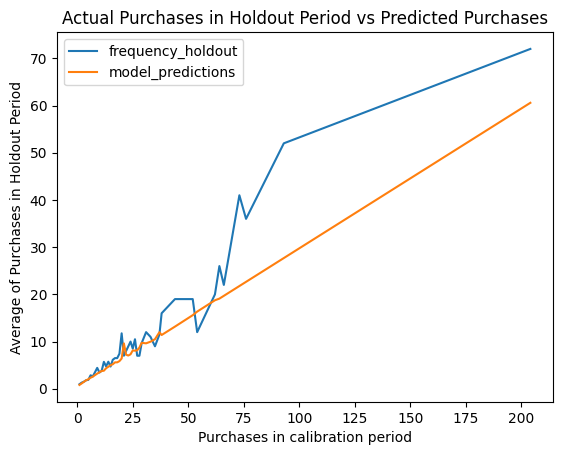

In [134]:
_ = plot_calibration_purchases_vs_holdout_purchases(
  bgf_engagement, 
  input_df, 
  n=holdout_days,
)

For low-frequency customers, the correlation is reliable, but for high-frequency ones, the model tends to be conservative, underestimating purchases. This may be influenced by a 90-day holdout ending on Dec 9, coinciding with the peak holiday shopping season when most consumers make more purchases. Using multi-year data for a more balanced holdout period is preferable.

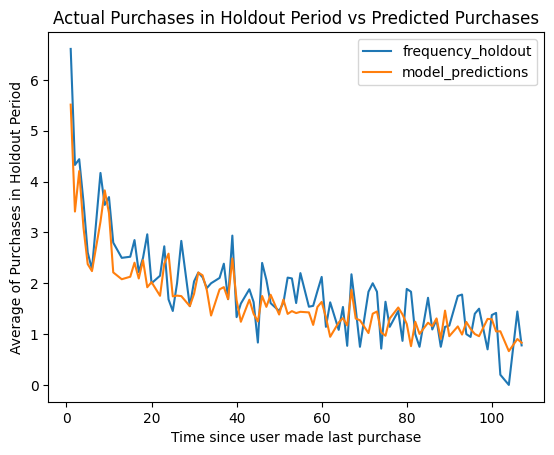

In [135]:
_ = plot_calibration_purchases_vs_holdout_purchases(
  bgf_engagement, 
  input_df,
  kind='time_since_last_purchase', 
  n=holdout_days,
)

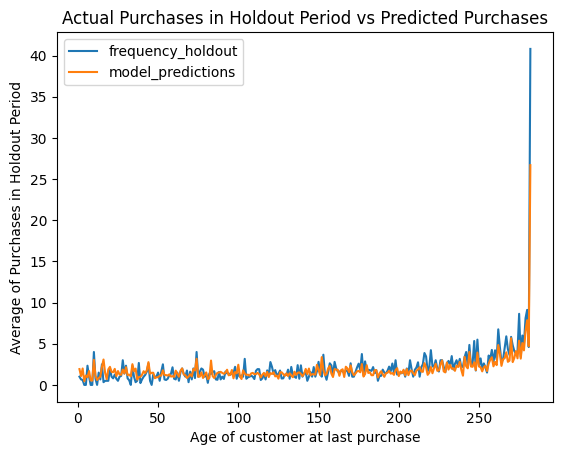

In [136]:
_ = plot_calibration_purchases_vs_holdout_purchases(
  bgf_engagement, 
  input_df, 
  kind='recency_cal', 
  n=300,
)

In [137]:
from btyd.plotting import plot_probability_alive_matrix

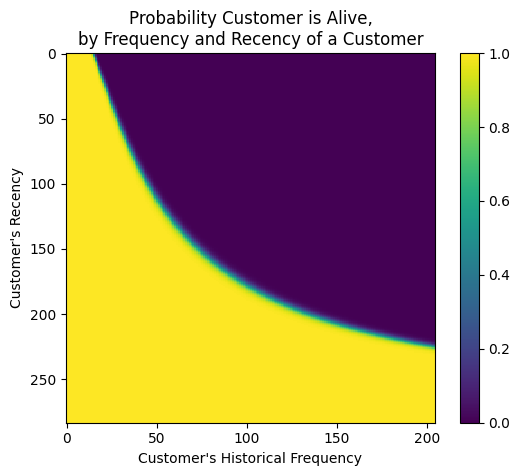

In [139]:
_ = plot_probability_alive_matrix(bgf_engagement)

In [140]:
from btyd.plotting import plot_frequency_recency_matrix

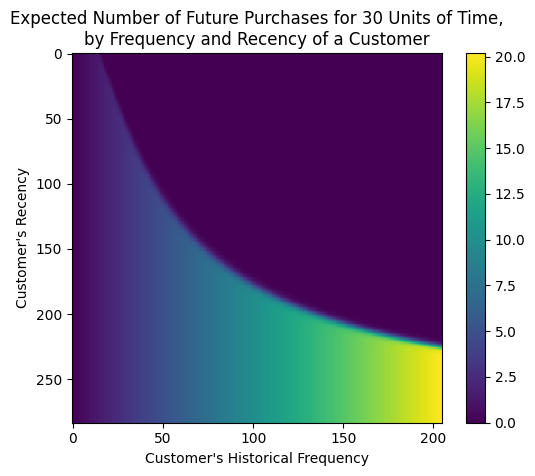

In [142]:
_ = plot_frequency_recency_matrix(bgf_engagement, T=30) 

#### Customer Spend Model

**The GammaGamma model** (named for the two gamma distributions is estimates) is used to estimate the monetary value of the spend in those periods. 

A key assumption of the GammaGamma model is that a customer's purchase frequency does not affect the monetary value of their spend.

In [143]:
btyd_spark.corr('frequency', 'monetary_value')

0.35951871283053255

In [144]:
from btyd import GammaGammaFitter

In [150]:
ggf_spend = GammaGammaFitter(penalizer_coef=0.002)

In [151]:
ggf_spend.fit(
    input_df['frequency_cal'],
    input_df['monetary_value_cal']
)

<btyd.GammaGammaFitter: fitted with 1966 subjects, p: 5.485842430190582, q: 0.5669519692225239, v: 8.469503788109085>

**Evaluate Model (RMSE)**

In [152]:
monetary_actual = input_df['monetary_value_holdout']

In [153]:
monetary_predicted = ggf_spend.conditional_expected_average_profit(
    input_df['frequency_holdout'],
    input_df['monetary_value_holdout']
)

In [154]:
mean_squared_error(monetary_actual, monetary_predicted, squared=False)

64.90250300279024

**Visualize Histograms for Actual & Predicted Spend**

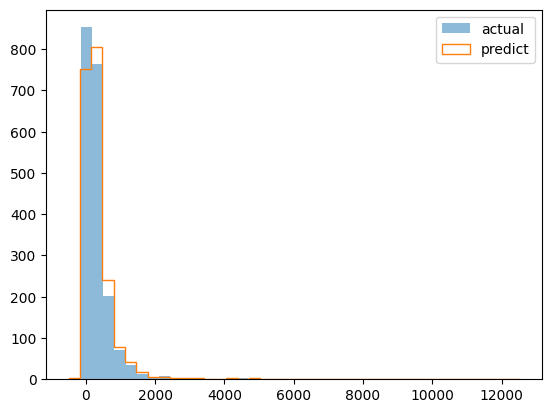

In [179]:
_ = plt.hist(monetary_actual, label='actual', bins=40, alpha=0.5)
_ = plt.hist(monetary_predicted, label='predict', histtype='step', bins=40, alpha=1)
_ = plt.legend(loc='upper right')

#### Customer Lifetime Value

Metric that indicates the total revenue a business can reasonably expect from a single customer account throughout the business relationship.

In [183]:
clv_df = filtered_btyd_spark.toPandas()

In [184]:
clv_df['clv'] = (
  ggf_spend.customer_lifetime_value(
      bgf_engagement,
      clv_df['frequency'],
      clv_df['recency'],
      clv_df['T'],
      clv_df['monetary_value'],
      time=12, # months
      discount_rate=0.01 # monthly discount rate ~ 12.7% annually
  )
)

In [188]:
clv_df.sort_values(by=['clv'], ascending=False)

,customerid,frequency,recency,T,monetary_value,clv
2796,NaN,276.0,373.0,373.0,5199.629783,1.233074e+06
1111,14646,46.0,353.0,354.0,6074.305652,2.546929e+05
2710,18102,26.0,367.0,367.0,8866.081538,2.048721e+05
2416,17450,32.0,359.0,367.0,5795.416563,1.641997e+05
834,14096,16.0,97.0,101.0,3568.791875,1.636987e+05
...,...,...,...,...,...,...
1381,15213,1.0,11.0,329.0,11.850000,3.094521e+01
2597,17816,3.0,329.0,365.0,6.783333,2.982042e+01
2290,17194,1.0,87.0,360.0,10.000000,2.583757e+01
1943,16454,2.0,196.0,240.0,3.450000,2.541408e+01


CLV is a powerful metric used by organizations to plan targeted promotional activities and assess customer equity. As such, it would be very helpful if we could convert our models into an easy to use function which we could employ in batch, streaming and interactive scenarios.